# 07MIAR_Proyecto_Programación - 01 CNN From Scratch

## 0. Librerías

In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from skimage.color import rgb2hsv
import json
import pandas as pd
from tensorflow.keras import Sequential
from keras.models import Model
from keras.layers import Dense, MaxPooling2D, BatchNormalization, Dropout, Conv2D, Flatten
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing import image
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from keras import regularizers
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

## 1. Lectura de los datos

### 1.1. Conexión remota con Google Drive

In [20]:
# Conexión remota con Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 1.2. Establecer ruta directa al directorio y lectura de datos

In [21]:
# Establecimiento de una ruta absoluta al directorio de Google Drive
BASE_FOLDER = "/content/drive/MyDrive/BASE_FOLDER/"
DATASET = BASE_FOLDER + "my_dataset/ohe_data_train_resize_224.h5"

In [22]:
# Lectura del dataset
df = pd.read_hdf(DATASET,key='data')

## 2. Red Neuronal Convolucional From Scratch

### 2.1. Función para crear la red neuronal

In [23]:
# Función para crear la red neuronal
def make_model():
    model = Sequential()
    model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu', padding='same',
                     input_shape=(224, 224, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))

    model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))

    model.add(Conv2D(filters=16, kernel_size=(5, 5), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=16, kernel_size=(5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))

    model.add(Flatten())

    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(12, activation='softmax'))

    return model

### 2.2. Análisis de la red neuronal

In [24]:
# Guardar el modelo en una variable
model = make_model()

# Visualización de las capas de la red neuronal
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 224, 224, 64)      4864      
                                                                 
 batch_normalization_16 (Ba  (None, 224, 224, 64)      256       
 tchNormalization)                                               
                                                                 
 conv2d_13 (Conv2D)          (None, 224, 224, 64)      102464    
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 112, 112, 64)      0         
 g2D)                                                            
                                                                 
 batch_normalization_17 (Ba  (None, 112, 112, 64)      256       
 tchNormalization)                                               
                                                      

## 3. Prepocesado de datos

In [25]:
# 'X' contiene las imágenes e 'y' contiene las etiquetas de las imágenes
X = np.array(df['imagen'].tolist())   # Convertir X a un arreglo NumPy
y = df.iloc[:, 1:]  # Selecciona todas las columnas excepto la primera (X)

# Dividir los datos en conjuntos de entrenamiento y prueba en un 20% del total y con una semilla de aleatoriedad constante
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Análisis de las dimensiones de los datos y etiquetas
print("Dimensiones de 'X_train':", X_train.shape)
print("Dimensiones de 'X_test':", X_test.shape)
print("Dimensiones de 'y_train':", y_train.shape)
print("Dimensiones de 'y_test':", y_test.shape)

Dimensiones de 'X_train': (3800, 224, 224, 3)
Dimensiones de 'X_test': (950, 224, 224, 3)
Dimensiones de 'y_train': (3800, 12)
Dimensiones de 'y_test': (950, 12)


### 3.1. Data augmentation

In [26]:
# Aplicación de 'data augmentation' para evitar 'overfitting'
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    fill_mode='nearest',
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2]
)

# Preparar el generador de datos para el conjunto de entrenamiento
train_generator = datagen.flow(X_train, y_train)
test_generator = datagen.flow(X_test, y_test)

## 4. Hiperparámetros y entrenamiento de la red neuronal

### 4.1. Hiperparámetros

In [27]:
# Hiperparámetros
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 0.01 * 0.9**x)   # Reduce el learning rate según avanza el entrenamiento por cada época
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15)   # Detiene el entrenamiento cuando se haya repetido el val_accuracy un número determinado de veces durante el entrenamiento (evita el overfitting)
epochs = 50   # Número de épocas
validation_split = 0.2    # Partición de los datos para validación
batch_size = 32   # Tamaño del lote de entrenamiento

### 4.2. Entrenamiento del modelo

In [28]:
# Entrenamiento
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("[INFO] Entrenando Red Neuronal...")
history = model.fit(X_train, y_train, epochs=epochs, callbacks=[reduce_lr, early_stop],
                    validation_split=validation_split, batch_size=batch_size)

[INFO] Entrenando Red Neuronal...
Epoch 1/50
95/95 [==============================] - 15s 113ms/step - loss: 2.4352 - accuracy: 0.3816 - val_loss: 67.3970 - val_accuracy: 0.1250 - lr: 0.0100
Epoch 2/50
95/95 [==============================] - 10s 107ms/step - loss: 1.6166 - accuracy: 0.5283 - val_loss: 5.4403 - val_accuracy: 0.3237 - lr: 0.0090
Epoch 3/50
95/95 [==============================] - 10s 107ms/step - loss: 1.1878 - accuracy: 0.6382 - val_loss: 1.5885 - val_accuracy: 0.6211 - lr: 0.0081
Epoch 4/50
95/95 [==============================] - 10s 107ms/step - loss: 0.9197 - accuracy: 0.7020 - val_loss: 1.4343 - val_accuracy: 0.5763 - lr: 0.0073
Epoch 5/50
95/95 [==============================] - 10s 107ms/step - loss: 0.8143 - accuracy: 0.7332 - val_loss: 1.5303 - val_accuracy: 0.6132 - lr: 0.0066
Epoch 6/50
95/95 [==============================] - 10s 107ms/step - loss: 0.6236 - accuracy: 0.7954 - val_loss: 1.1316 - val_accuracy: 0.6408 - lr: 0.0059
Epoch 7/50
95/95 [===========

## 5. Evaluación del modelo

### 5.1. Análisis de 'test loss' y 'test accuracy'

In [29]:
# 'Test loss' y 'test accuracy'
print("[INFO] Evaluando Red Neuronal...")
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

[INFO] Evaluando Red Neuronal...
30/30 [==============================] - 2s 53ms/step - loss: 0.6532 - accuracy: 0.8442
Test loss: 0.6532420516014099
Test accuracy: 0.8442105054855347


### 5.2. Representación gráfica

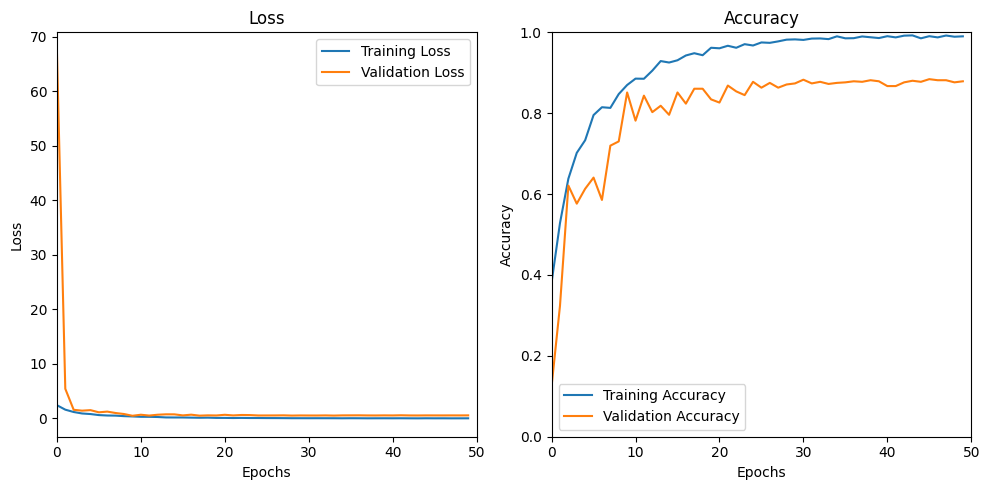

In [30]:
def plot_learning_curves(history):
    plt.figure(figsize=(10, 5))

    # Plot de pérdida
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xlim(0, len(history.history['loss']))  # Establece límites para el eje x
    plt.legend()

    # Plot de precisión
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)  # Establece límites para el eje y
    plt.xlim(0, len(history.history['accuracy']))  # Establece límites para el eje x
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_learning_curves(history)

### 5.3. Matriz de confusión

30/30 [==============================] - 1s 18ms/step


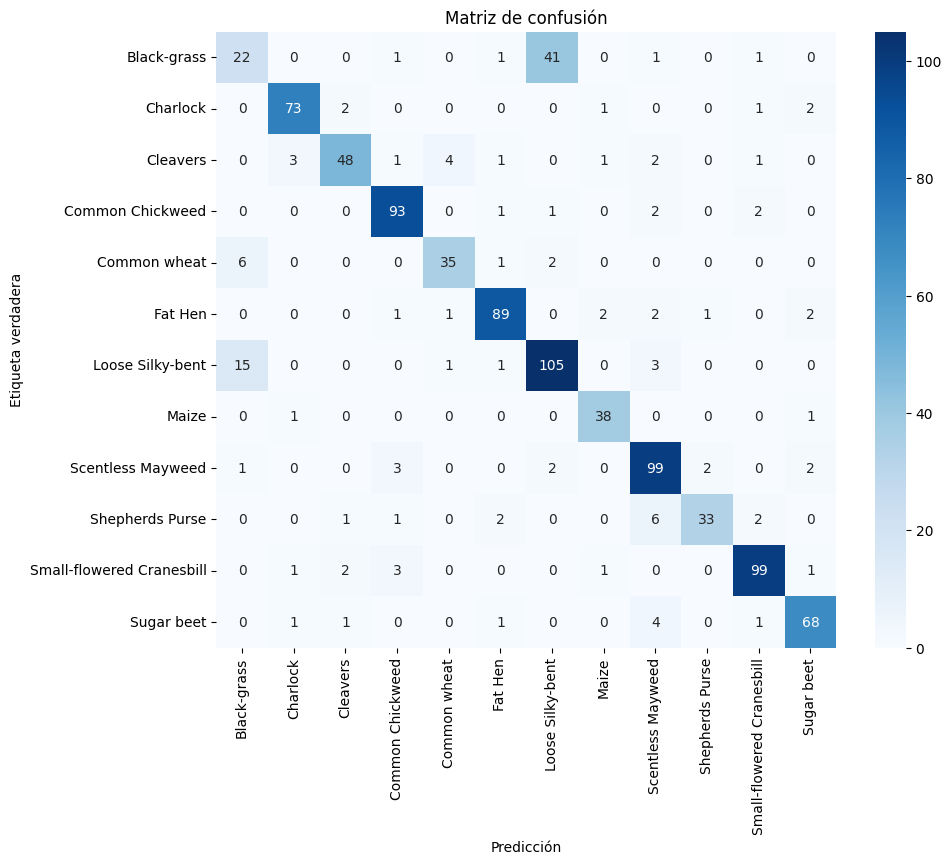

In [31]:
# Obtener predicciones del conjunto de prueba
Y_pred = model.predict(X_test)

# Convertir las predicciones de las clases en etiquetas
y_pred_classes = np.argmax(Y_pred, axis=1)
y_true = np.argmax(y_test.values, axis=1)

# Calcular la matriz de confusión
confusion_mtx = confusion_matrix(y_true, y_pred_classes)
clases = [
    "Black-grass",
    "Charlock",
    "Cleavers",
    "Common Chickweed",
    "Common wheat",
    "Fat Hen",
    "Loose Silky-bent",
    "Maize",
    "Scentless Mayweed",
    "Shepherds Purse",
    "Small-flowered Cranesbill",
    "Sugar beet"
]

# Visualizar la matriz de confusión
def confusion_matrix_plot(confusion_mtx, clases):
  plt.figure(figsize=(10, 8))
  sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=clases, yticklabels=clases)
  plt.xlabel('Predicción')
  plt.ylabel('Etiqueta verdadera')
  plt.title('Matriz de confusión')
  plt.show()

confusion_matrix_plot(confusion_mtx=confusion_mtx, clases=clases)

## 6. Guardado del modelo

In [32]:
# Guardado del modelo
model.save(BASE_FOLDER + "/models/GMaster/modelo_GMaster_88.h5")